# GLOVe-LSA-SVM
- Uses LSA to capture latent features
- Uses SVM to find optimal hyperplane of separation

In [1]:
## IMPORTS
# GLOVE Embeddings
import spacy

# LSA
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

# SVM
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterGrid, StratifiedKFold
import scipy.stats as stats
from joblib import parallel_backend

# Preprocessing
import csv
import chardet
import numpy as np
import re
import pandas as pd
import demoji
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import json

# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/walnuts/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load the dataset / read csv
# MAKE SURE CSV IS IN UTF-8 (if tweets have emojis)

## Testing if csv can open (Use for troubleshooting)
# with open('Eng_Tweets.csv') as csv_file:
#   csvFile = csv.reader(csv_file, delimiter=',')
#   for row in csv_file:
#     print(row)

## RUN PARAMETERS
LANG = 4  # 1 = English | 2 = Tagalog | 3 = TagLish | 4 = Mixed
DO_GRIDSEARCH = False
manual_params = { # If not using GridSearchCV
    'probability': True,
    'C': 1,
    'kernel': 'linear',
    'class_weight': None,
    'random_state': 42
}

pd.set_option('display.max_colwidth', None)

# Assign the CSV path based on LANG value
if LANG == 1:
    csv_path = 'Eng_Tweets.csv'
elif LANG == 2:
    csv_path = 'Tag_Tweets.csv'
elif LANG == 3:
    csv_path = 'TagLish_Tweets.csv'
elif LANG == 4:
    csv_path = 'Mixed_Tweets.csv'
else:
    raise ValueError("Invalid value for LANG. Must be 1, 2, 3, or 4.")


df = pd.read_csv(csv_path)
print("total rows: " + str(len(df)))
df.head() ## head won't show emojis unless using print function

total rows: 4995


,Username,Tweet,Date posted,Label
0,@fudaishii,i'm genuinely going to attempt tonight i can't do this anymore i can't handle all this stress i wish i was never born bro,9/11/24,1.0
1,@yourdystiny,"Becoming less reactive is a huge part of growth & decreasing stress. If you let everything get you worked up, you’ll damage your mind, body & spirit.",9/8/24,0.0
2,@ocenhxu,me ??? tired ??? stressed ??? exhausted ??? i wanna cry ??? yes.,9/8/24,1.0
3,@ifeelgoodto,"skipping meals, irregular sleeping habits, overthinking, stress, tired and drained. that's me, that's my everyday life",9/10/24,1.0
4,@ysuckme,"you deserve to be happy. not confused, not hurt, not stressed, just happy.",9/8/24,0.0


## Preprocessing
- Remove mentions (@)
- Remove hashtags (#)
- Remove URLs
- Replace emojis with textual description (Using demoji)
- Remove stop words

In [3]:
### PREPROCESSING STEPS (FOR TAGALOG)
with open('tl_stopwords.json', 'r') as f:
    tagalog_stop_words = json.load(f)

# Preprocessing functions
def clean_text_tl(text):
    # Remove mentions
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Replace emoji with textual descriptions
    text = demoji.replace_with_desc(text)
    text = re.sub(r'(:[a-zA-Z\s]+:)', r' \1 ', text)  # Add spaces around the shortcode
    text = re.sub(r'(:[a-zA-Z\s]+:)', lambda match: match.group(0).replace(' ', '_'), text)
    text = text.strip()
    return text

def remove_stopwords_tl(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in tagalog_stop_words]
    return ' '.join(filtered_words)

In [4]:
### PREPROCESSING STEPS
def clean_text(text):
  # Remove mentions
  text = re.sub(r'@[A-Za-z0-9_]+', '', text)
  # Remove hashtags
  text = re.sub(r'#\w+', '', text)
  # Remove URLs
  text = re.sub(r'http\S+|www\S+|https\S+', '', text)
  # Replace emoji with textual descriptions
  text = demoji.replace_with_desc(text)
  text = re.sub(r'(:[a-zA-Z\s]+:)', r' \1 ', text) # Add spaces around the shortcode
  text = re.sub(r'(:[a-zA-Z\s]+:)', lambda match: match.group(0).replace(' ', '_'), text)
  text = text.strip()
  return text

stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
  words = text.split()
  filtered_words = [word for word in words if word.lower() not in stop_words]
  return ' '.join(filtered_words)

df = df.dropna() # Get rid of NaN rows

In [5]:
## Execute preprocessing
df = df.dropna()  # Get rid of NaN rows

if LANG == 1:
    print("EXECUTING ENGLISH TWEET CLEANING")
    df['Tweet'] = df['Tweet'].apply(clean_text)
    df['Tweet'] = df['Tweet'].apply(remove_stopwords)
elif LANG == 2:
    print("EXECUTING TAGALOG TWEET CLEANING")
    df['Tweet'] = df['Tweet'].apply(clean_text_tl)
    df['Tweet'] = df['Tweet'].apply(remove_stopwords_tl)
else:
    print("EXECUTING BOTH ENGLISH AND TAGALOG TWEET CLEANING")
    df['Tweet'] = df['Tweet'].apply(clean_text_tl)
    df['Tweet'] = df['Tweet'].apply(remove_stopwords_tl)
    df['Tweet'] = df['Tweet'].apply(clean_text)
    df['Tweet'] = df['Tweet'].apply(remove_stopwords)
    

df.head()

EXECUTING BOTH ENGLISH AND TAGALOG TWEET CLEANING


,Username,Tweet,Date posted,Label
0,@fudaishii,i'm genuinely going attempt tonight can't anymore can't handle stress wish never born bro,9/11/24,1.0
1,@yourdystiny,"Becoming less reactive huge part growth & decreasing stress. let everything get worked up, you’ll damage mind, body & spirit.",9/8/24,0.0
2,@ocenhxu,??? tired ??? stressed ??? exhausted ??? wanna cry ??? yes.,9/8/24,1.0
3,@ifeelgoodto,"skipping meals, irregular sleeping habits, overthinking, stress, tired drained. that's me, that's everyday life",9/10/24,1.0
4,@ysuckme,"deserve happy. confused, hurt, stressed, happy.",9/8/24,0.0


In [6]:
df['Label'].value_counts()

Label
0.0    3659
1.0    1335
Name: count, dtype: int64

## GloVe Embeddings
- Make sure to run "python -m spacy download en_core_web_md"
- GloVe embeddings are then averaged and standardized
- Train-Test-Validation split = 70% - 20% - 10%
- Uses undersampling to balance the training set

In [7]:
nlp = spacy.load("en_core_web_md", disable=["tagger", "parser", "ner"]) # disable non word-embedding parts of spacy

# Create an empty list to store the embeddings
embeddings = []

# Iterate through the DataFrame
for index, row in df.iterrows():
    tweet = row['Tweet']
    doc = nlp(tweet)

    # Get the embeddings for each token and store them
    tweet_embeddings = [token.vector for token in doc]
    embeddings.append(tweet_embeddings)

# Add the embeddings to the DataFrame as a new column
df['embeddings'] = embeddings

/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check

In [8]:
# Function to average embeddings for a tweet
def average_embeddings(embeddings_list):
    if embeddings_list:
        return np.mean(embeddings_list, axis=0)
    else:
        return np.zeros(300)  # 300 = embedding dimension

In [9]:
# Function to split the dataset into train, validation, and test
def split_data(df, train_size=0.7, val_size=0.1, test_size=0.2):
    # 70% into training 30% into validation + testing 
    train_df, temp_df = train_test_split(df, train_size=train_size, random_state=42)
    
    # 30% splits 10% into validation and 20% into testing
    val_df, test_df = train_test_split(temp_df, train_size=val_size / (val_size + test_size), random_state=42)
    
    return train_df, val_df, test_df

In [10]:
# Average the sentence embedding into a single entry
df['avg_embedding'] = df['embeddings'].apply(average_embeddings)

# Split the dataset
train_df, val_df, test_df = split_data(df)

X_train = np.array(train_df['avg_embedding'].to_list())
y_train = train_df['Label']
X_val = np.array(val_df['avg_embedding'].to_list())
y_val = val_df['Label']
X_test = np.array(test_df['avg_embedding'].to_list())
y_test = test_df['Label']

# UNDERSAMPLING
# undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
# X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# OVERSAMPLING
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Class distribution after undersampling:\n{pd.Series(y_train_resampled).value_counts()}")

Class distribution after undersampling:
Label
1.0    2580
0.0    2580
Name: count, dtype: int64


In [11]:
np.set_printoptions(linewidth=200)  # Increase linewidth to fit more in a row
print("Averaged Glove embeddings:")
print(df.loc[0, 'avg_embedding'])

Averaged Glove embeddings:
[-7.06352353e-01  1.78621799e-01 -3.16151351e-01 -1.89257994e-01 -7.80870616e-02  1.04641758e-01  7.14401901e-02 -3.07269424e-01  9.94581133e-02  2.00123882e+00 -1.39243469e-01 -2.22805887e-02
  1.84803531e-02  9.14731324e-02 -2.67876506e-01 -5.59489392e-02 -2.13040560e-02  3.90589446e-01 -7.35513493e-02  1.34178251e-01  6.18738718e-02  8.06470576e-04  1.46613076e-01 -2.00203359e-01
 -1.34678828e-02 -1.16536885e-01 -2.37409249e-01 -2.23987728e-01  1.49625123e-01 -1.40616357e-01 -1.26576066e-01  1.68735459e-01 -1.28252015e-01 -5.17503545e-02  5.42461723e-02  3.50671679e-01
  1.52729124e-01  5.38464040e-02 -1.15303636e-01  6.99241236e-02 -1.50172427e-01 -7.58571178e-02 -1.72877893e-01  1.81052074e-01  1.31359652e-01  7.48350343e-04  1.12650199e-02  2.11694449e-01
 -1.29441902e-01 -1.80861801e-02 -1.87942132e-01  2.11081207e-01  8.10847133e-02  2.58171987e-02 -1.96084697e-02  1.05538554e-01 -3.88949215e-02 -3.83855961e-02  9.10718814e-02 -3.30785960e-02
 -1.0855

## LSA (Latent Semantic Analysis)
- Also uses standard scaler for standardization of values

In [12]:
# Apply LSA (Latent Semantic Analysis) for dimensionality reduction
lsa = TruncatedSVD(n_components=100, random_state=42) 

X_train_lsa = lsa.fit_transform(X_train_resampled)
X_val_lsa = lsa.transform(X_val)
X_test_lsa = lsa.transform(X_test)

# Standardization (scaling)
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_lsa)
X_val = scaler.transform(X_val_lsa)
X_test = scaler.transform(X_test_lsa)

In [13]:
print("Length of training set after LSA dimensionality reduction: ", len(X_train_lsa))
print(X_train_lsa)

Length of training set after LSA dimensionality reduction:  5160
[[-3.29831052e+00  5.02565205e-01 -3.24442893e-01 ...  1.68238338e-02 -1.09514922e-01  4.37770151e-02]
 [-2.78131223e+00  5.59176683e-01  8.41196179e-01 ...  4.84109893e-02  1.66452955e-02 -1.53323999e-02]
 [-2.47256351e+00 -3.42391521e-01 -1.33671895e-01 ... -1.12011202e-01 -1.69020206e-01 -1.12062255e-02]
 ...
 [-3.40360188e+00  3.06651771e-01 -3.94560456e-01 ...  2.74062380e-02  5.04837818e-02 -3.15896124e-02]
 [-7.85724103e-01 -2.59030485e+00 -8.05838406e-01 ... -2.72396598e-02  2.21997257e-02  2.38714606e-01]
 [-1.06833017e+00 -2.43610930e+00 -4.53221500e-01 ... -3.43948719e-03 -3.58522777e-03  2.37141689e-03]]


## SVM (Support Vector Machine)

In [14]:
# Modify param_grid for linear kernel
if DO_GRIDSEARCH:
    param_grid_linear = {
        'C': [100],
        'kernel': ['linear'],  # Only linear kernel
        'class_weight': [None, 'balanced'],  # Class weight
    }
    
    # Stratified K Fold
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Initialize the SVC model
    svc = SVC(probability=True)
    
    # Define the GridSearchCV object with StratifiedKFold
    grid_search_linear = GridSearchCV(
        estimator=svc,
        param_grid=param_grid_linear,
        cv=stratified_kfold,
        n_jobs=-1,
        verbose=3,
        scoring='accuracy'
    )
    
    # Fit the grid search to the training data
    with parallel_backend('multiprocessing'):
        grid_search_linear.fit(X_train_final, y_train_resampled)
    
    # Get the best parameters and best score for linear kernel
    best_params_linear = grid_search_linear.best_params_
    best_score_linear = grid_search_linear.best_score_
    
    # Print the results for linear kernel
    print(f"Best parameters for linear kernel: {best_params_linear}")
    print(f"Best cross-validation Accuracy for linear kernel: {best_score_linear:.4f}")
else:
    print("Skipped GridSearchCV")

Skipped GridSearchCV


In [15]:
# Using the best parameters from grid search or random search
if DO_GRIDSEARCH:
    best_model = grid_search.best_estimator_  # or 
    # best_model = random_search.best_estimator_
else:
    # Manual plug and fit
    best_model = SVC(**manual_params)
    best_model.fit(X_train_final, y_train_resampled)

# Final evaluation on the test set
y_pred_test = best_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {accuracy_test}")

Test Accuracy: 0.716


Validation Accuracy: 0.7394789579158316
Validation Precision: 0.5352112676056338
Validation Recall: 0.7862068965517242
Validation F1 Score: 0.6368715083798883
Validation Balanced Accuracy: 0.7532729398012858
Validation Confusion Matrix: 
[[255  99]
 [ 31 114]]
Test Accuracy: 0.716
Test Precision: 0.48872180451127817
Test Recall: 0.7090909090909091
Test F1 Score: 0.5786350148367952
Test Balanced Accuracy: 0.7138557993730408
Test Confusion Matrix: 
[[521 204]
 [ 80 195]]
Test ROC AUC: 0.7984501567398118


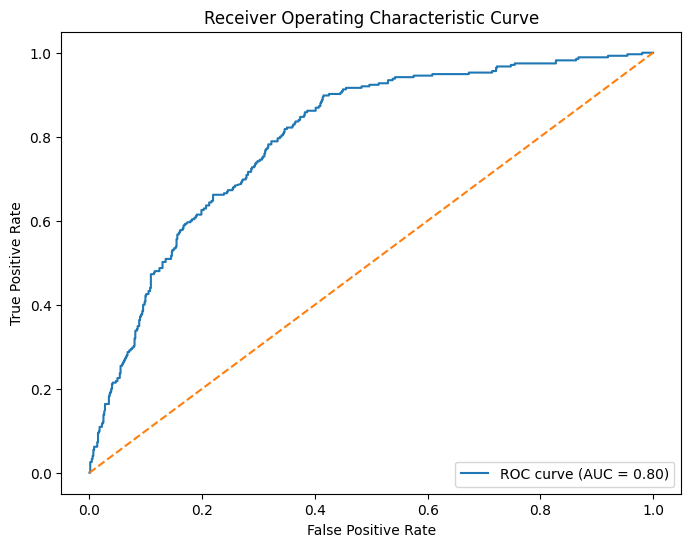

In [16]:
# Evaluation on validation set
y_pred_val = best_model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1_val = f1_score(y_val, y_pred_val)
balanced_acc_val = balanced_accuracy_score(y_val, y_pred_val)  # Add balanced accuracy
conf_matrix_val = confusion_matrix(y_val, y_pred_val)

print(f"Validation Accuracy: {accuracy_val}")
print(f"Validation Precision: {precision_val}")
print(f"Validation Recall: {recall_val}")
print(f"Validation F1 Score: {f1_val}")
print(f"Validation Balanced Accuracy: {balanced_acc_val}")  # Print balanced accuracy
print(f"Validation Confusion Matrix: \n{conf_matrix_val}")

# Final evaluation on test set
y_pred_test = best_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
balanced_acc_test = balanced_accuracy_score(y_test, y_pred_test)  # Add balanced accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

print(f"Test Accuracy: {accuracy_test}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")
print(f"Test F1 Score: {f1_test}")
print(f"Test Balanced Accuracy: {balanced_acc_test}")  # Print balanced accuracy
print(f"Test Confusion Matrix: \n{conf_matrix_test}")

# Compute ROC AUC
y_prob_test = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
roc_auc = roc_auc_score(y_test, y_prob_test)
print(f"Test ROC AUC: {roc_auc}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()

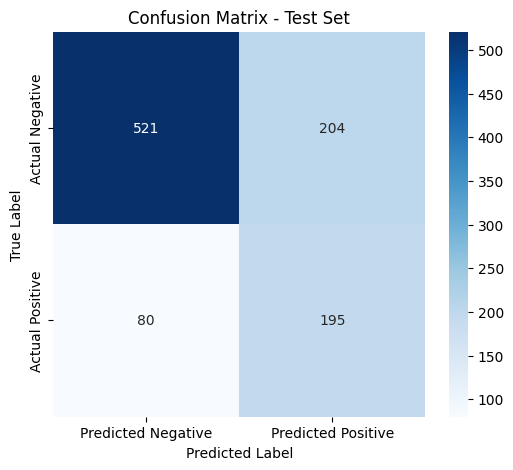

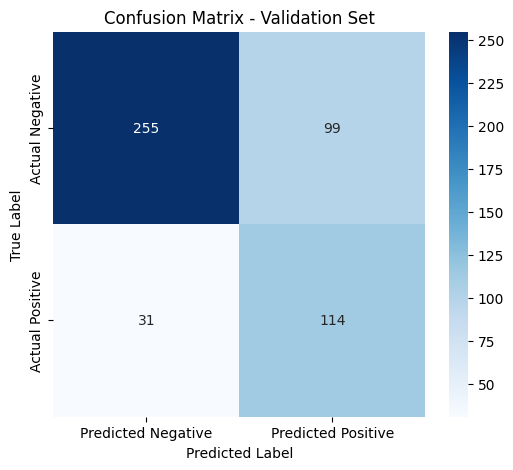

In [17]:
# Plot confusion matrix for test set
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot confusion matrix for validation set
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix - Validation Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Final Training Score: 0.8033
Final Cross-validation Score: 0.7866


/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
2 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/sklear

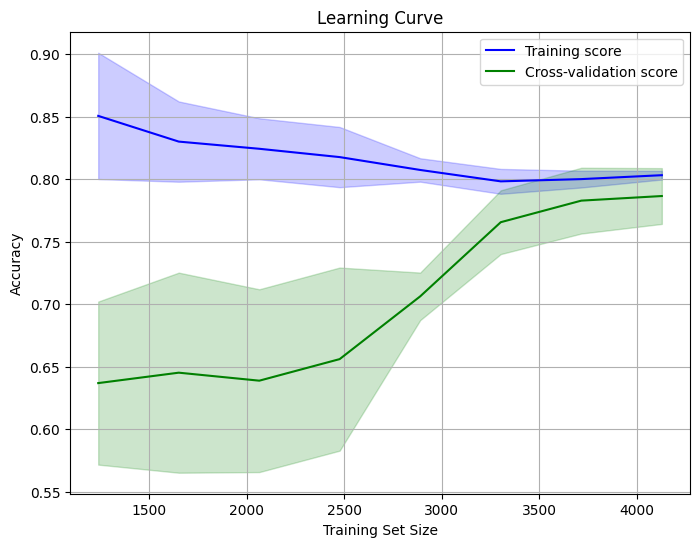

In [18]:
# Using StratifiedKFold for cross-validation
stratified_cv = StratifiedKFold(n_splits=5)

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_final, y_train_resampled, cv=stratified_cv,  # Use StratifiedKFold
    scoring='accuracy', 
    train_sizes=np.linspace(0.1, 1.0, 10), 
    n_jobs=-1
)

# Calculate the mean and standard deviation of train and test scores
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)

# Print the final scores (for the largest training set size)
print(f"Final Training Score: {train_scores_mean[-1]:.4f}")
print(f"Final Cross-validation Score: {test_scores_mean[-1]:.4f}")

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='green')

# Fill the area between the curve and the axis to represent the standard deviation
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color='green', alpha=0.2)

# Add labels and title
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [19]:
import os
import pickle

# Assign the CSV path based on LANG value
if LANG == 1:
    path = 'English'
elif LANG == 2:
    path = 'Tagalog'
elif LANG == 3:
    path = 'Taglish'
elif LANG == 4:
    path = 'Mixed'

os.makedirs('saved_models/' + path, exist_ok=True)

# save the model
model_path = 'saved_models/' + path + '/Glove-LSA-SVM_' + path + '.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)

print("Model saved successfully!")

Model saved successfully!
